# Plot Frontend

Plots statistics and data collected from the frontend related to feature detection,
RANSAC pose recovery, sparse stereo matching and timing.

In [84]:
import yaml
import os
import copy
import pandas as pd
import numpy as np

import logging
log = logging.getLogger(__name__)
log.setLevel(logging.INFO)
if not log.handlers:
    ch = logging.StreamHandler()
    ch.setLevel(logging.INFO)
    ch.setFormatter(logging.Formatter('%(levelname)s - %(message)s'))
    log.addHandler(ch)
    
from evo.tools import file_interface
from evo.tools import plot
from evo.tools import pandas_bridge

from evo.core import sync
from evo.core import trajectory
from evo.core import metrics
from evo.core import transformations
from evo.core import lie_algebra as lie

%matplotlib inline
# %matplotlib notebook
import matplotlib.pyplot as plt

## Data Locations

Make sure to set the following paths.

`vio_output_dir` is the path to the directory containing `output_*.csv` files obtained from logging a run of SparkVio.

`gt_data_file` is the absolute path to the `csv` file containing ground truth data for the absolute pose at each timestamp of the dataset.

In [85]:
# Define directory to VIO output csv files as well as ground truth absolute poses.
# vio_output_dir = "/home/marcus/code/VIO/output_logs/test_3/"
vio_output_dir = "/home/marcus/catkin_ws/src/spark_vio_ros/output_logs/test_1/"
# gt_data_file = "/home/marcus/datasets/V1_01_easy/mav0/state_groundtruth_estimate0/data.csv"
gt_data_file = "/home/marcus/catkin_ws/src/spark_vio_ros/output_logs/test_1/output_gt_poses.csv"

## Frontend Statistics

Calculate and plot important statistics from the frontend of the VIO module

These statistics include the number of tracked and detected features, data relating the RANSAC runs for both mono 5-point and stereo 3-point methods, timing data and sparse-stereo-matching statistics.

In [86]:
# Parse frontend statistics csv file.
stats_file = os.path.join(os.path.expandvars(vio_output_dir), "output_frontend_stats.csv")

# Convert to tidy pandas DataFrame object.
df_stats = pd.read_csv(stats_file, sep=',', index_col=False)

In [87]:
# Helper functions for processing data summary.
def get_mean(attrib):
    ls = df_stats[attrib].tolist()
    return float(sum(ls)) / len(ls)

def get_min(attrib):
    return min(df_stats[attrib])

def get_max(attrib):
    return max(df_stats[attrib])

# Construct and visualize summary. TODO(marcus): use a LaTeX table.
summary_stats = [
    ("Average number of detected features", get_mean("nrDetectedFeatures")),
    ("Minimum number of detected features", get_min("nrDetectedFeatures")),
    ("Average number of tracked features" , get_mean("nrTrackerFeatures")),
    ("Minimum number of tracked features", get_min("nrTrackerFeatures")),
    ("Average number of mono ransac inliers", get_mean("nrMonoInliers")),
    ("Minimum number of mono ransac inliers", get_min("nrMonoInliers")),
    ("Average number of stereo ransac inliers", get_mean("nrStereoInliers")),
    ("Minimum number of stereo ransac inliers", get_min("nrStereoInliers")),
    ("Average number of mono ransac putatives", get_mean("nrMonoPutatives")),
    ("Minimum number of mono ransac putatives", get_min("nrMonoPutatives")),
    ("Average number of stereo ransac putatives", get_mean("nrStereoPutatives")),
    ("Minimum number of stereo ransac putatives", get_min("nrStereoPutatives")),
]

attrib_len = [len(attrib[0]) for attrib in summary_stats]
max_attrib_len = max(attrib_len)

print "\nStatistic summary:\n"
for entry in summary_stats:
    attrib = entry[0]
    value = entry[1]
    spacing = max_attrib_len - len(attrib)
    print attrib + " "*spacing + ": " + str(value)


Statistic summary:

Average number of detected features      : 0.0
Minimum number of detected features      : 0
Average number of tracked features       : 258.340807175
Minimum number of tracked features       : 6
Average number of mono ransac inliers    : 220.035874439
Minimum number of mono ransac inliers    : 50
Average number of stereo ransac inliers  : 77.2331838565
Minimum number of stereo ransac inliers  : 2
Average number of mono ransac putatives  : 258.869955157
Minimum number of mono ransac putatives  : 104
Average number of stereo ransac putatives: 85.7085201794
Minimum number of stereo ransac putatives: 4


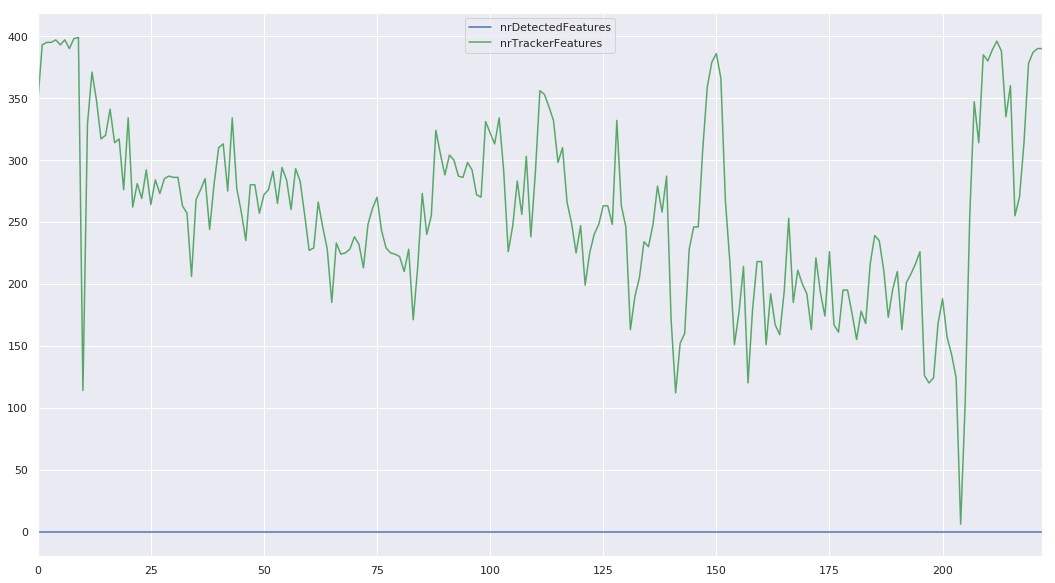

In [88]:
# Plot feature tracking statistics.
fig0, axes0 = plt.subplots(nrows=1, ncols=1, figsize=(18,10), squeeze=False)

df_stats.plot(kind="line", y="nrDetectedFeatures", ax=axes0[0,0])
df_stats.plot(kind="line", y="nrTrackerFeatures", ax=axes0[0,0])

plt.show()

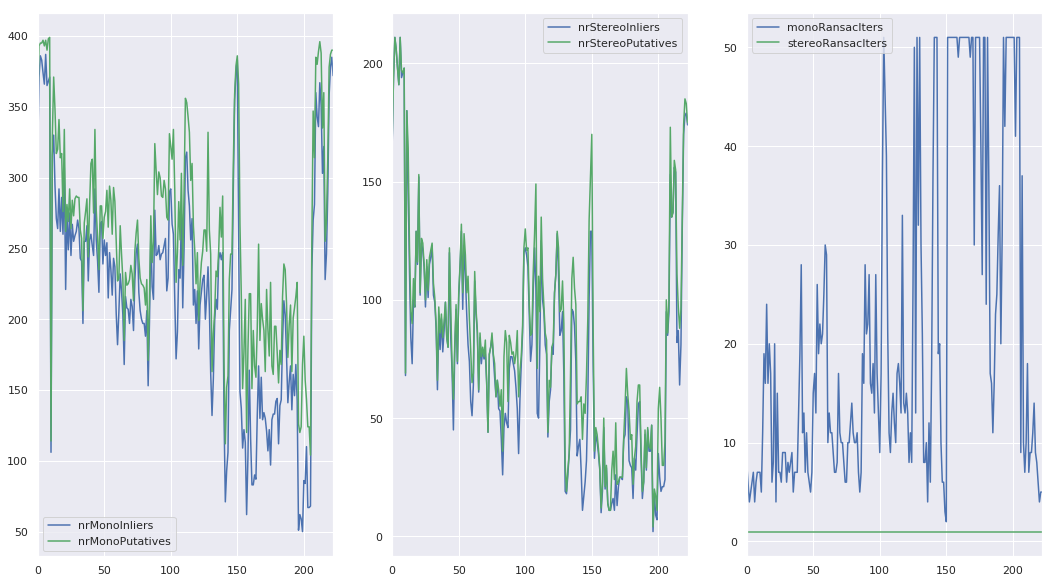

In [89]:
# Plot ransac inlier, putative and iteration statistics.

fig1, axes1 = plt.subplots(nrows=1, ncols=3, figsize=(18,10), squeeze=False)

df_stats.plot(kind="line", y="nrMonoInliers", ax=axes1[0,0])
df_stats.plot(kind="line", y="nrMonoPutatives", ax=axes1[0,0])
df_stats.plot(kind="line", y="nrStereoInliers", ax=axes1[0,1])
df_stats.plot(kind="line", y="nrStereoPutatives", ax=axes1[0,1])
df_stats.plot(kind="line", y="monoRansacIters", ax=axes1[0,2])
df_stats.plot(kind="line", y="stereoRansacIters", ax=axes1[0,2])

plt.show()

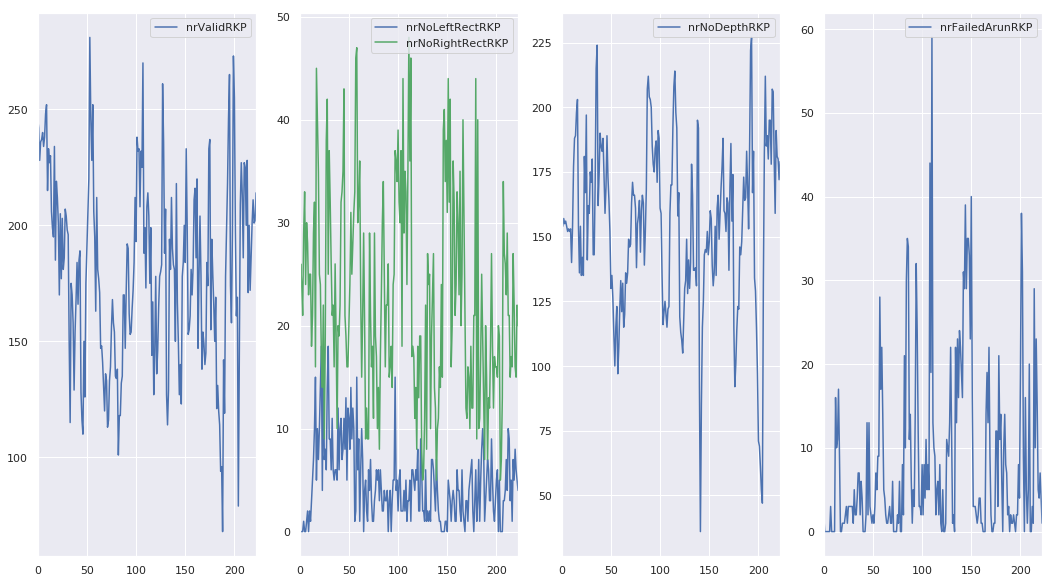

In [90]:
# Plot sparse-stereo-matching statistics.

fig3, axes3 = plt.subplots(nrows=1, ncols=4, figsize=(18,10), squeeze=False)

df_stats.plot(kind="line", y="nrValidRKP", ax=axes3[0,0])
df_stats.plot(kind="line", y="nrNoLeftRectRKP", ax=axes3[0,1])
df_stats.plot(kind="line", y="nrNoRightRectRKP", ax=axes3[0,1])
df_stats.plot(kind="line", y="nrNoDepthRKP", ax=axes3[0,2])
df_stats.plot(kind="line", y="nrFailedArunRKP", ax=axes3[0,3])

plt.show()

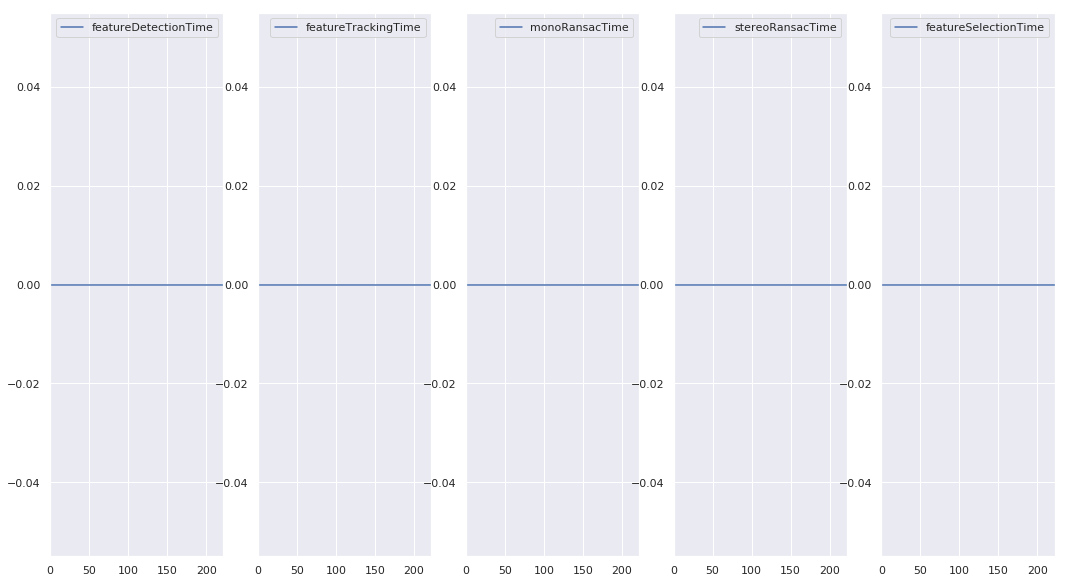

In [91]:
# Plot timing statistics.

fig2, axes2 = plt.subplots(nrows=1, ncols=5, figsize=(18,10), squeeze=False)

df_stats.plot(kind="line", y="featureDetectionTime", ax=axes2[0,0])
df_stats.plot(kind="line", y="featureTrackingTime", ax=axes2[0,1])
df_stats.plot(kind="line", y="monoRansacTime", ax=axes2[0,2])
df_stats.plot(kind="line", y="stereoRansacTime", ax=axes2[0,3])
df_stats.plot(kind="line", y="featureSelectionTime", ax=axes2[0,4])

plt.show()

## Useful Methods for RANSAC Visualization

In [92]:
# Useful methods for RPE calculation.

def get_rpe(data, metric):
    """ Gets RPE and RPE statistics for two trajectories and a given pose_relation.
        
        Args:
            data:   tuple of trajectories, the first being the reference trajectory
                    and the second being the estimated trajectory.
            metric: a metrics.PoseRelation instance representing the pose relation
                    to use when computing RPE.
        
        Returns:
            A metrics.RPE instance containing the RPE for both trajectories according
            to the given metric.
    """
    # normal mode
    delta = 1
    delta_unit = metrics.Unit.frames
    all_pairs = False

    rpe = metrics.RPE(metric, delta, delta_unit, all_pairs)
    rpe.process_data(data)
    return rpe


def plot_rpe(x_axis, rpe, size=(18,10)):
    """ Plots RPE error against time for a given metrics.RPE instance.
    
        Args:
            x_axis: An array-type of values for all the x-axis values (time).
            rpe:    A metrics.RPE instance with pre-processed data.
    """
    fig = plt.figure(figsize=size)
    plot.error_array(fig, rpe.error, x_array=x_axis, statistics=rpe.get_all_statistics(), 
                     name="RPE", title="RPE w.r.t. " + rpe.pose_relation.value, xlabel="$t$ (s)")
    plt.show()


def rename_euroc_gt_df(df):
    """ Renames a DataFrame built from a EuRoC ground-truth data csv file to be easier to read.
        
        Column labels are changed to be more readable and to be identical to the generic pose 
        trajectory format used with other csv files. Note that '#timestamp' will not actually 
        be renamed if it is the index of the DataFrame (which it should be). It will be 
        appropriately renamed if it is the index name.
        This operation is 'inplace': It does not return a new DataFrame but simply changes
        the existing one.
        
        Args:
            df: A pandas.DataFrame object.
    """
    df.index.names = ["timestamp"]
    df.rename(columns={" p_RS_R_x [m]": "x",
                       " p_RS_R_y [m]": "y",
                       " p_RS_R_z [m]": "z",
                       " q_RS_w []": "qw",
                       " q_RS_x []": "qx",
                       " q_RS_y []": "qy",
                       " q_RS_z []": "qz",
                       " v_RS_R_x [m s^-1]": "vx",
                       " v_RS_R_y [m s^-1]": "vy",
                       " v_RS_R_z [m s^-1]": "vz",
                       " b_w_RS_S_x [rad s^-1]": "bgx",
                       " b_w_RS_S_y [rad s^-1]": "bgy",
                       " b_w_RS_S_z [rad s^-1]": "bgz",
                       " b_a_RS_S_x [m s^-2]": "bax",
                       " b_a_RS_S_y [m s^-2]": "bay",
                       " b_a_RS_S_z [m s^-2]": "baz"}, inplace=True)


def time_associate_df(ref_df, est_df):
    """ Returns a copy of the reference DataFrame sliced row-wise so as to only contain rows
        used in the estimated DataFrame.
        
        The argument 'ref_df' is the reference DataFrame and is sliced to only contain rows
        that are in 'est_df' as well. Rows with 'NaN' values are dropped from the resulting
        DataFrame before returning.
        
        Args:
            ref_df: A pandas.DataFrame object representing the reference trajectory.
            est_df: A pandas.DataFrame object representing the estimated trajectory.
        
        Returns:
            res: A pandas.DataFrame object containing only the rows of 'ref_df' whos
            indices are present in 'est_df'.
    """
    res = ref_df.reindex(index=est_df.index)
    res.dropna(inplace=True)
    return res


# TODO(marcus): implement the inverse operation to this one:
# TODO(marcus): move to a library somewhere and write a unit test.
def convert_abs_traj_to_rel_traj(df, to_scale=True):
    """ Converts an absolute-pose trajectory to a relative-pose trajectory.
    
        The incoming DataFrame is processed element-wise. At each timestamp (which is the 
        index of the DataFrame row) starting from the second (index 1), the relative pose 
        from the previous timestamp to the current one is calculated (in the previous-
        timestamp's coordinate frame). This relative pose is then appended to the 
        resulting DataFrame.
        The resulting DataFrame has timestamp indices corresponding to poses that represent
        the relative transformation between that timestamp and the **next** one.
        
        Args:
            df: A pandas.DataFrame object with timestamps as indices containing, at a minimum,
                columns representing the xyz position and wxyz quaternion-rotation at each
                timestamp, corresponding to the absolute pose at that time.
            to_scale: A boolean. If set to False, relative poses will have their translation
                part normalized.
        
        Returns:
            A pandas.DataFrame object with xyz position and wxyz quaternion fields for the 
            relative pose trajectory corresponding to the absolute one given in 'df'.
    """
    rows_list = []
    
    prev_ts = df.index[0]
    for i in range(len(df.index[1:])):
        ts = df.index[i]
        
        w_t_bi = np.array([df.at[prev_ts, idx] for idx in ['x', 'y', 'z']])
        w_q_bi = np.array([df.at[prev_ts, idx] for idx in ['qw', 'qx', 'qy', 'qz']])
        w_T_bi = transformations.quaternion_matrix(w_q_bi)
        w_T_bi[:3,3] = w_t_bi
        
        w_t_bidelta = np.array([df.at[ts, idx] for idx in ['x', 'y', 'z']])
        w_q_bidelta = np.array([df.at[ts, idx] for idx in ['qw', 'qx', 'qy', 'qz']])    
        w_T_bidelta = transformations.quaternion_matrix(w_q_bidelta)
        w_T_bidelta[:3,3] = w_t_bidelta
        
        bi_T_bidelta = lie.relative_se3(w_T_bi, w_T_bidelta)
        
        bi_R_bidelta = copy.deepcopy(bi_T_bidelta)
        bi_R_bidelta[:,3] = np.array([0, 0, 0, 1])
        bi_q_bidelta = transformations.quaternion_from_matrix(bi_R_bidelta)
        bi_t_bidelta = bi_T_bidelta[:3,3]
        
        if not to_scale:
            norm = np.linalg.norm(bi_t_bidelta)
            if norm > 1e-6:
                bi_t_bidelta = bi_t_bidelta / np.linalg.norm(bi_t_bidelta)
        
        new_row = {'x': bi_t_bidelta[0], 'y': bi_t_bidelta[1], 'z': bi_t_bidelta[2],
                   'qw': bi_q_bidelta[0], 'qx': bi_q_bidelta[1], 'qy': bi_q_bidelta[2],
                   'qz': bi_q_bidelta[3],}
        rows_list.append(new_row)
        prev_ts = ts
        
    return pd.DataFrame(data=rows_list, index=df.index[:-1])

# Frontend Mono Ransac Poses (RPE)

Calculate relative-pose-error (RPE) for the mono ransac poses obtained in the frontend.

These are relative poses between keyframes and do not represent an entire trajectory. As such, they cannot be processed using the normal EVO evaluation pipeline.

We import the csv data as Pandas DataFrame objects and perform our own data association. Relative poses for ground truth data are computed explicitly here. Rotation error and translation error (up to a scaling factor) are then calculated for each pair of consecutive keyframes.

This gives insight into the accuracy of the RANSAC 5-point method employed in the frontend.


NOTE: gt_df is read from the ground-truth csv. It expects the timestamp to be the first column. Make sure to comment out `rename_euroc_gt_df(gt_df)` in the second cell below if you are not using a csv with the EuRoC header.

In [93]:
# Load ground truth and estimated data as csv DataFrames.
gt_df = pd.read_csv(gt_data_file, sep=',', index_col=0)

ransac_mono_filename = os.path.join(os.path.expandvars(vio_output_dir), "output_frontend_ransac_mono.csv")
mono_df = pd.read_csv(ransac_mono_filename, sep=',', index_col=0)

In [94]:
gt_df = gt_df[~gt_df.index.duplicated()]

In [95]:
# First make gt_df prettier.
rename_euroc_gt_df(gt_df)

# Associate timestamps between the two DataFrames to get a gt DataFrame with only associated timestamps.
gt_rel_df = time_associate_df(gt_df, mono_df)

# Convert the absolute poses (world frame) of the gt DataFrame to relative poses.
gt_rel_df = convert_abs_traj_to_rel_traj(gt_rel_df, to_scale=False)

# Save this relative-pose ground truth file to disk as a csv for later use, if needed.
# gt_rel_filename = "/home/marcus/output_gt_rel_poses_mono.csv"
# gt_rel_df.to_csv(filename, sep=',', columns=['x', 'y', 'z', 'qw', 'qx', 'qy', 'qz'])

In [96]:
# Convert the gt relative-pose DataFrame to a trajectory object.
traj_ref = pandas_bridge.df_to_trajectory(gt_rel_df)

# Use the mono ransac file as estimated trajectory.
# traj_est_unassociated = file_interface.read_swe_csv_trajectory(ransac_mono_filename)
traj_est_unassociated = pandas_bridge.df_to_trajectory(mono_df)

print "traj_ref: ", traj_ref
print "traj_est: ", traj_est_unassociated

# Associate the data.
traj_est = copy.deepcopy(traj_est_unassociated)
traj_ref, traj_est = sync.associate_trajectories(traj_ref, traj_est)

print "traj_ref: ", traj_ref
print "traj_est: ", traj_est

traj_ref:  216 poses, 26.359m path length, 50.543s duration
traj_est:  223 poses, 25.830m path length, 50.743s duration
traj_ref:  216 poses, 26.359m path length, 50.543s duration
traj_est:  216 poses, 25.754m path length, 50.543s duration


In [97]:
# Get RPE for entire relative trajectory.
rpe_rot = get_rpe((traj_ref, traj_est), metrics.PoseRelation.rotation_angle_deg)
rpe_tran = get_rpe((traj_ref, traj_est), metrics.PoseRelation.translation_part)

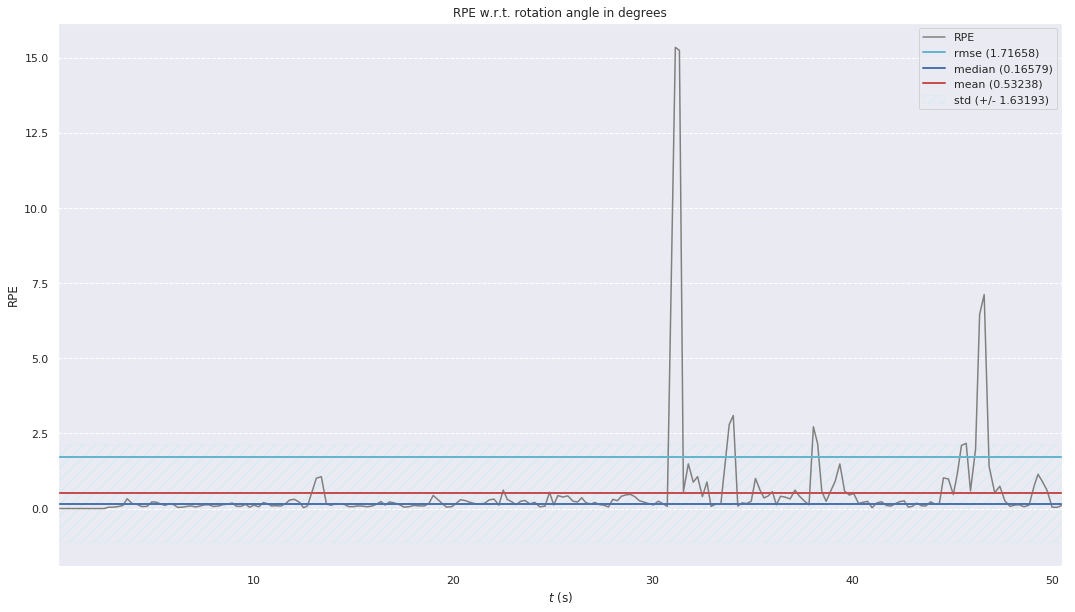

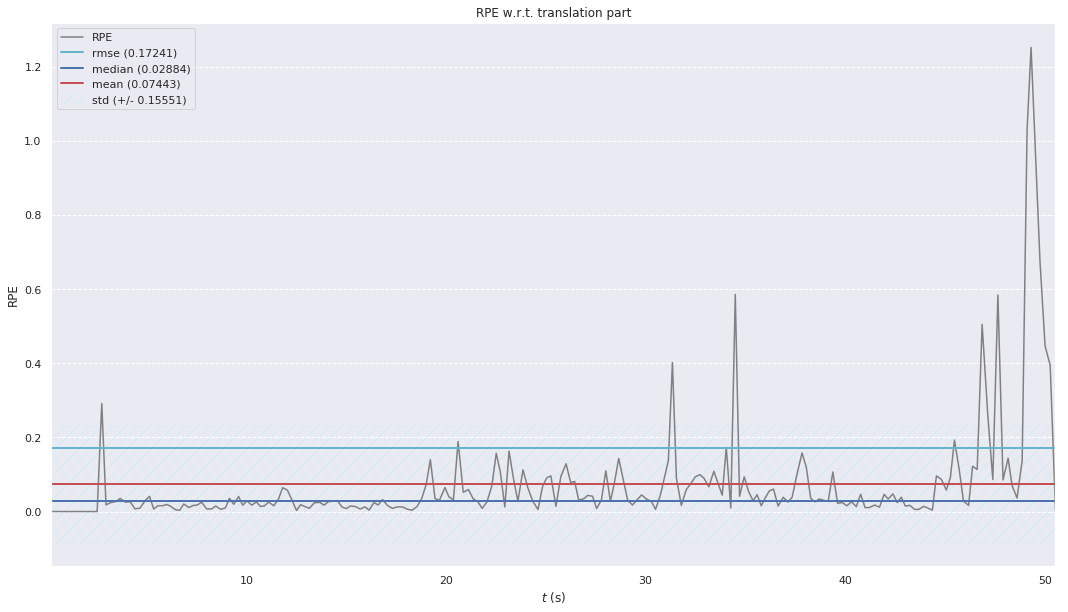

In [98]:
# Plot RPE of trajectory rotation and translation parts.

# important: restrict data to delta ids for plot.
traj_ref_plot = copy.deepcopy(traj_ref)
traj_est_plot = copy.deepcopy(traj_est)
traj_ref_plot.reduce_to_ids(rpe_rot.delta_ids)
traj_est_plot.reduce_to_ids(rpe_rot.delta_ids)
seconds_from_start = [t - traj_est.timestamps[0] for t in traj_est.timestamps[1:]]

plot_rpe(seconds_from_start, rpe_rot)
plot_rpe(seconds_from_start, rpe_tran)

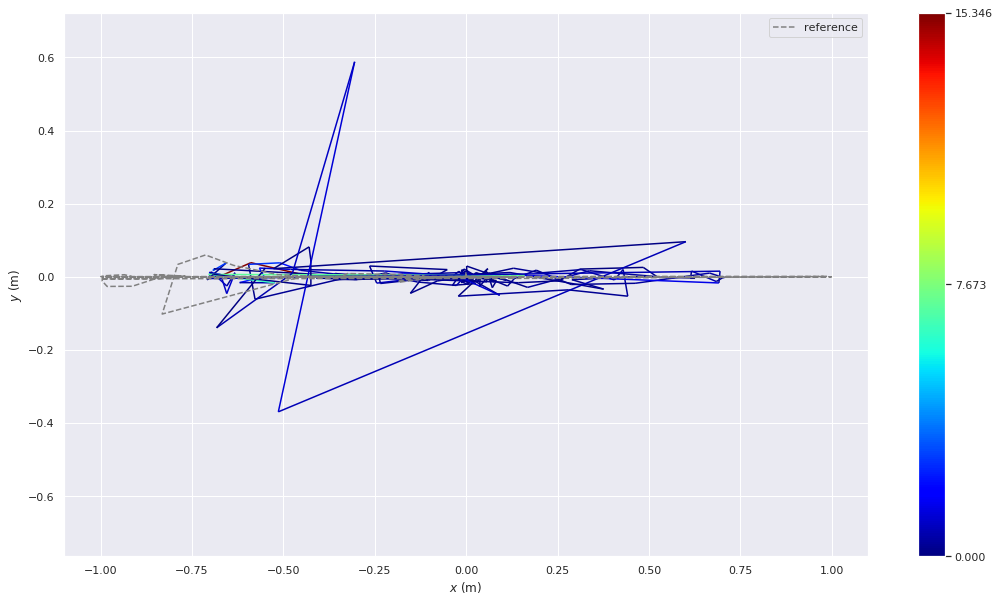

In [99]:
# Plot the relative trajectories against each other. This is only for visualizing large error.
# TODO(marcus): decide on usefulness.

plot_mode = plot.PlotMode.xy
fig = plt.figure(figsize=(18,10))
ax = plot.prepare_axis(fig, plot_mode)
plot.traj(ax, plot_mode, traj_ref_plot, '--', "gray", "reference")
plot.traj_colormap(ax, traj_est_plot, rpe_rot.error, plot_mode,
                   min_map=rpe_rot.get_all_statistics()["min"],
                   max_map=rpe_rot.get_all_statistics()["max"])
ax.legend()
plt.show()

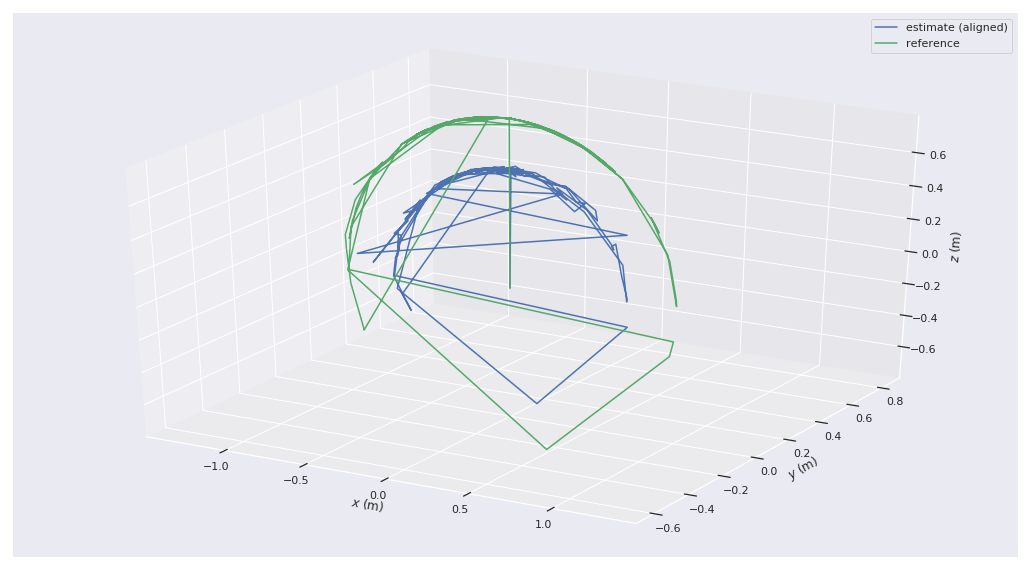

In [100]:
# Plot the trajectories for quick error visualization.
# TODO(marcus): decide on usefulness.

fig = plt.figure(figsize=(18,10))
traj_by_label = {
    "estimate (aligned)": traj_est,
    "reference": traj_ref
}
plot.trajectories(fig, traj_by_label, plot.PlotMode.xyz)
plt.show()

# Frontend Stereo Ransac Poses (RPE)

Calculate relative-pose-error (RPE) for the stereo ransac poses obtained in the frontend.

This is done in the same way as in the mono module.

This gives insight into the accuracy of the RANSAC 3-point method employed in the frontend.

NOTE: gt_df is read from the ground-truth csv. It expects the timestamp to be the first column. Make sure to comment out `rename_euroc_gt_df(gt_df)` in the second cell below if you are not using a csv with the EuRoC header.

In [101]:
# Load ground truth and estimated data as csv DataFrames.
gt_df = pd.read_csv(gt_data_file, sep=',', index_col=0)

ransac_stereo_filename = os.path.join(os.path.expandvars(vio_output_dir), "output_frontend_ransac_stereo.csv")
stereo_df = pd.read_csv(ransac_stereo_filename, sep=',', index_col=0)

In [102]:
gt_df = gt_df[~gt_df.index.duplicated()]

In [103]:
# First make gt_df prettier.
rename_euroc_gt_df(gt_df)

# Associate timestamps between the two DataFrames to get a gt DataFrame with only associated timestamps.
gt_rel_df = time_associate_df(gt_df, stereo_df)

# Convert the absolute poses (world frame) of the gt DataFrame to relative poses.
gt_rel_df = convert_abs_traj_to_rel_traj(gt_rel_df, to_scale=True)

# Save this relative-pose ground truth file to disk as a csv for later use, if needed.
# gt_rel_filename = "/home/marcus/output_gt_rel_poses_mono.csv"
# gt_rel_df.to_csv(filename, sep=',', columns=['x', 'y', 'z', 'qw', 'qx', 'qy', 'qz'])

In [104]:
# Convert the gt relative-pose DataFrame to a trajectory object.
traj_ref = pandas_bridge.df_to_trajectory(gt_rel_df)

# Use the mono ransac file as estimated trajectory.
# traj_est_unassociated = file_interface.read_swe_csv_trajectory(ransac_mono_filename)
traj_est_unassociated = pandas_bridge.df_to_trajectory(stereo_df)

# Associate the data.
traj_est = copy.deepcopy(traj_est_unassociated)
traj_ref, traj_est = sync.associate_trajectories(traj_ref, traj_est)

print "traj_ref: ", traj_ref
print "traj_est: ", traj_est

traj_ref:  216 poses, 30.661m path length, 50.543s duration
traj_est:  216 poses, 81.041m path length, 50.543s duration


In [105]:
# Get RPE for entire relative trajectory.
rpe_rot = get_rpe((traj_ref, traj_est), metrics.PoseRelation.rotation_angle_deg)
rpe_tran = get_rpe((traj_ref, traj_est), metrics.PoseRelation.translation_part)

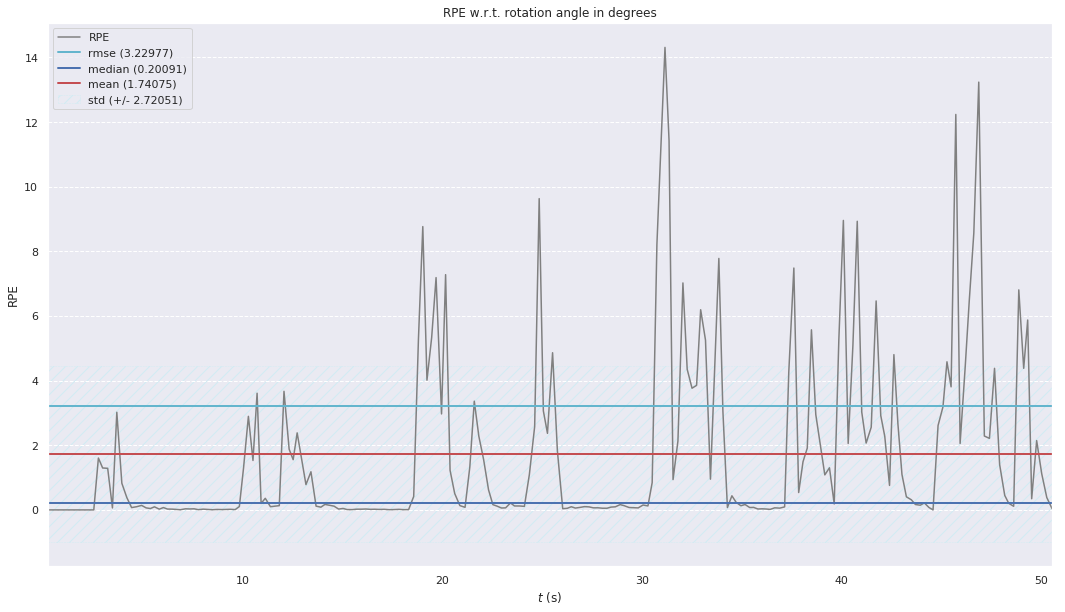

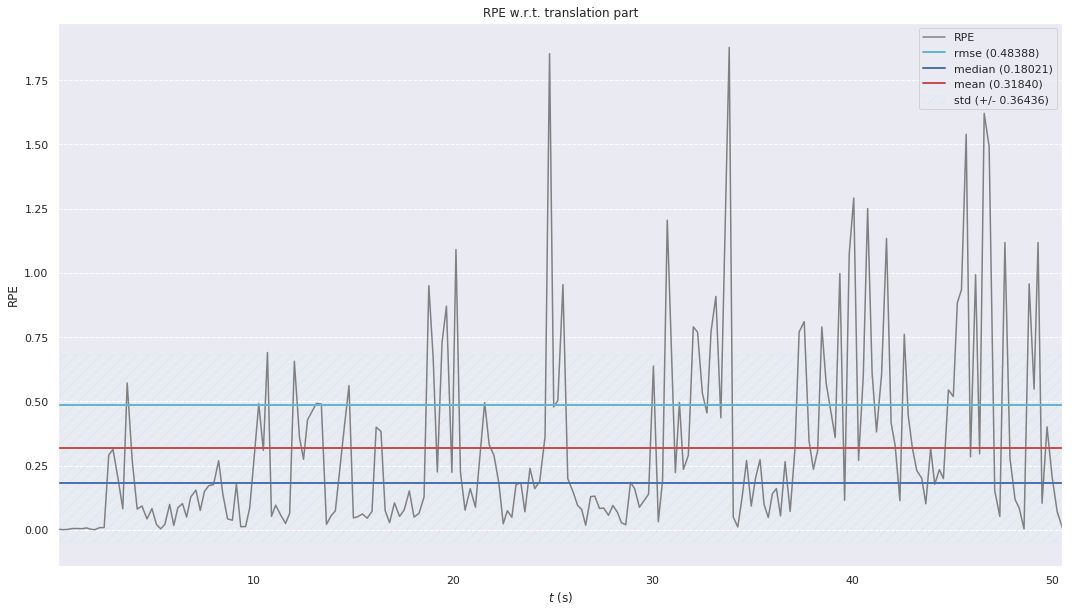

In [106]:
# Plot RPE of trajectory rotation and translation parts.

# important: restrict data to delta ids for plot.
traj_ref_plot = copy.deepcopy(traj_ref)
traj_est_plot = copy.deepcopy(traj_est)
traj_ref_plot.reduce_to_ids(rpe_rot.delta_ids)
traj_est_plot.reduce_to_ids(rpe_rot.delta_ids)
seconds_from_start = [t - traj_est.timestamps[0] for t in traj_est.timestamps[1:]]

plot_rpe(seconds_from_start, rpe_rot)
plot_rpe(seconds_from_start, rpe_tran)

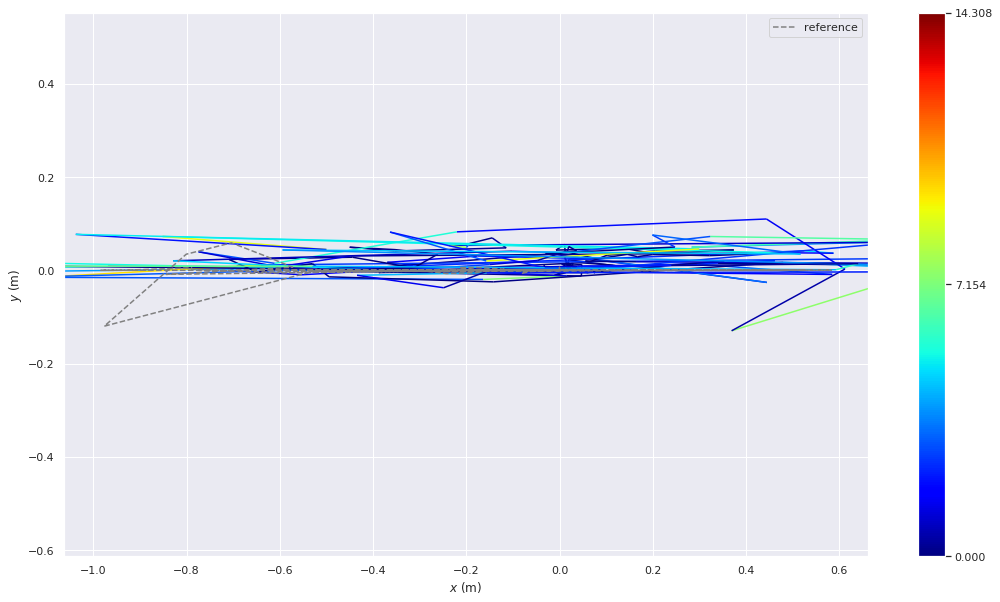

In [107]:
# Plot the relative trajectories against each other. This is only for visualizing large error.
# TODO(marcus): decide on usefulness.

plot_mode = plot.PlotMode.xy
fig = plt.figure(figsize=(18,10))
ax = plot.prepare_axis(fig, plot_mode)
plot.traj(ax, plot_mode, traj_ref_plot, '--', "gray", "reference")
plot.traj_colormap(ax, traj_est_plot, rpe_rot.error, plot_mode,
                   min_map=rpe_rot.get_all_statistics()["min"],
                   max_map=rpe_rot.get_all_statistics()["max"])
ax.legend()
plt.show()

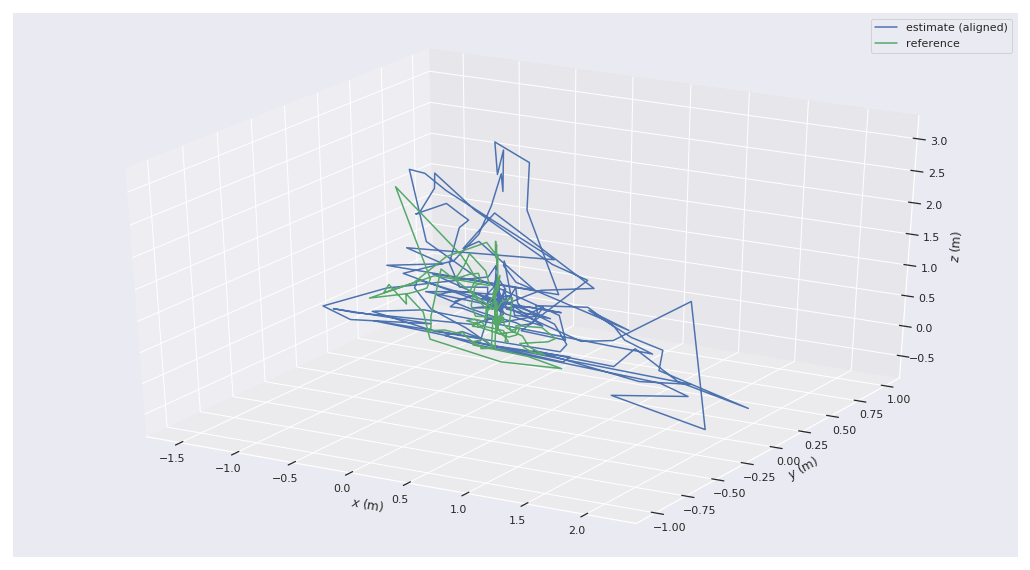

In [109]:
# Plot the trajectories for quick error visualization.
# TODO(marcus): decide on usefulness.

fig = plt.figure(figsize=(18,10))
traj_by_label = {
    "estimate (aligned)": traj_est,
    "reference": traj_ref
}
plot.trajectories(fig, traj_by_label, plot.PlotMode.xyz)
plt.show()